<a href="https://colab.research.google.com/github/JasmithaM14/Modelling/blob/main/CLASSWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyLDAvis
!pip install gensim
!pip install nltk
!pip install seaborn
!pip install sklearn
!pip install textblob

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


** Libraries **

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
from gensim import corpora
import networkx as nx
from sklearn.manifold import TSNE
from gensim.corpora import Dictionary
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from textblob import TextBlob


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data Preprocessing and Exploratory Data Analysis (EDA) ###

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text
0  The question in this election: Who can put the...
1  Last night, Donald Trump said not paying taxes...
2  Couldn't be more proud of @HillaryClinton. Her...
3  If we stand together, there's nothing we can't...
4  Both candidates were asked about how they'd co...
Data preprocessing complete. Cleaned data saved to '/content/drive/MyDrive/cleaned_tweets.csv'.
Basic Statistics of the dataset:
                      Text
count                 6444
unique                6280
top     make america great
freq                    19


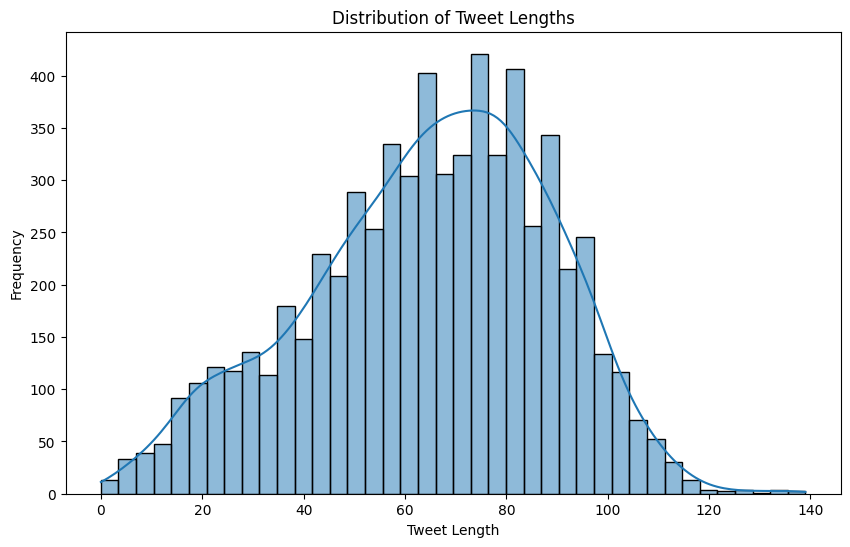

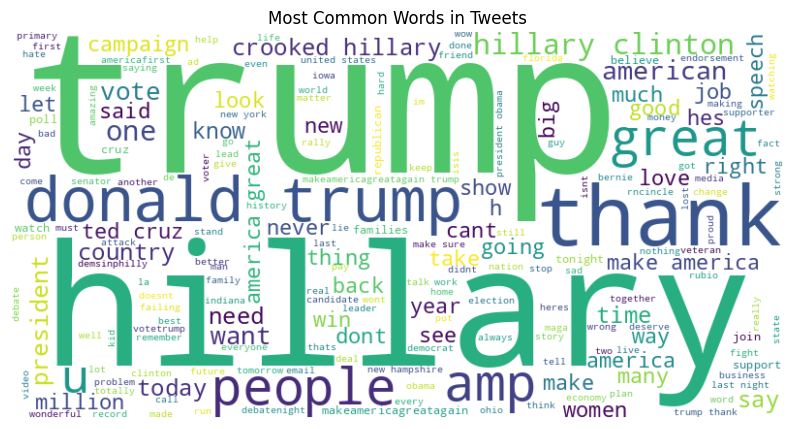

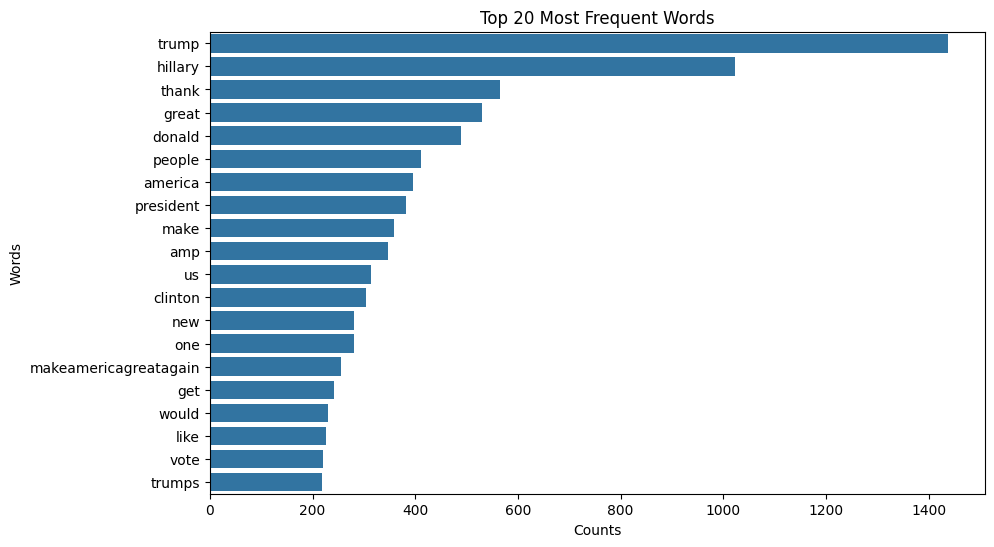

In [ ]:
# Download the stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the dataset
file_path = '/content/drive/MyDrive/tweets_text.csv'
tweets_df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
print(tweets_df.head())

# Data Preprocessing Function
def preprocess_tweet(tweet):
    # Ensure the tweet is a string
    if not isinstance(tweet, str):
        return ""
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#'
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    return tweet

# Apply preprocessing to the 'text' column
tweets_df['Text'] = tweets_df['text'].apply(preprocess_tweet)

# Select only the Text column for the output file
cleaned_df = tweets_df[['Text']]

# Save the cleaned dataset for further use
cleaned_file_path = '/content/drive/MyDrive/cleaned_tweets.csv'
cleaned_df.to_csv(cleaned_file_path, index=False)

print(f"Data preprocessing complete. Cleaned data saved to '{cleaned_file_path}'.")

# Exploratory Data Analysis (EDA)

# 1. Basic Statistics
print("Basic Statistics of the dataset:")
print(cleaned_df.describe())

# 2. Distribution of tweet lengths
tweet_lengths = cleaned_df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(tweet_lengths, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# 3. Most common words
all_words = ' '.join(cleaned_df['Text'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Tweets')
plt.show()

# 4. Top 20 most frequent words
word_counts = Counter(all_words.split())
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Counts')
plt.ylabel('Words')
plt.show()


**Applying LDA model**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Column Names in the Dataset: Index(['Text'], dtype='object')


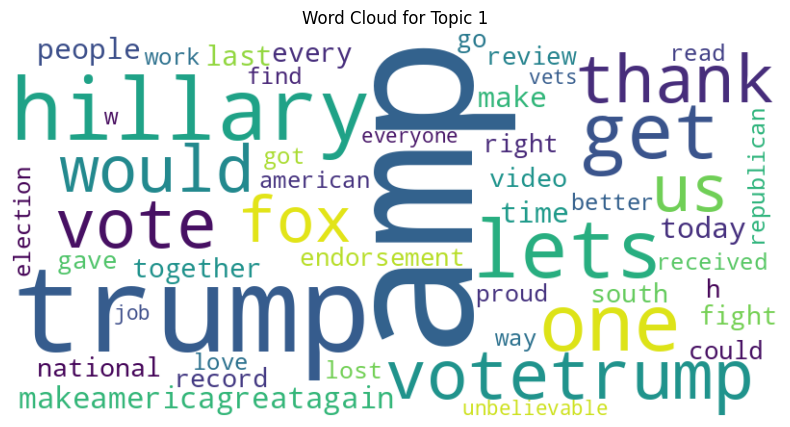

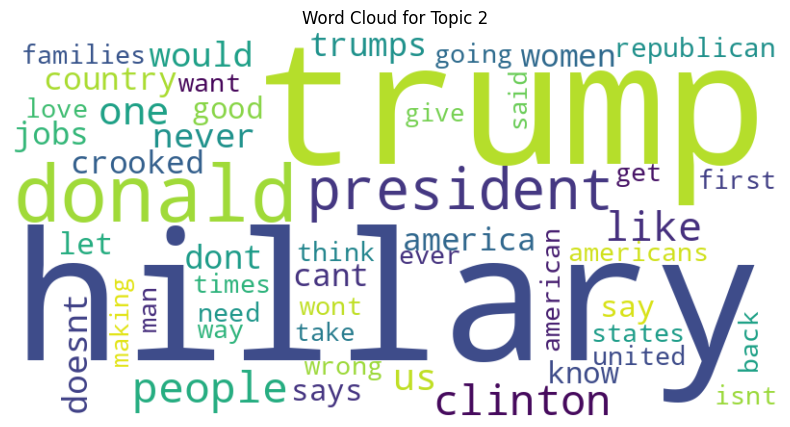

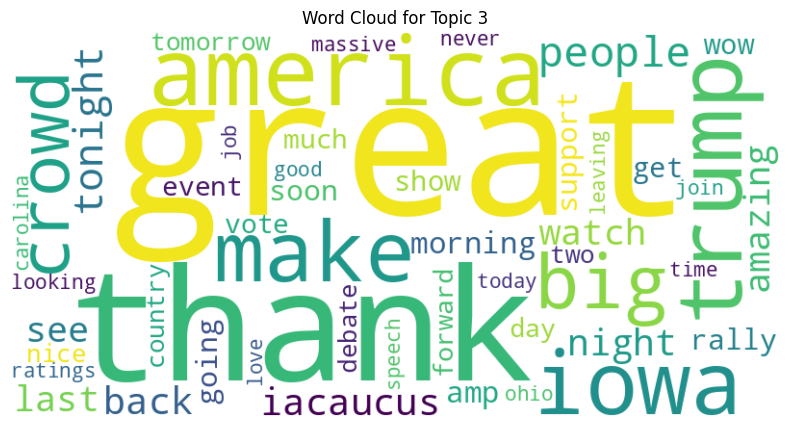

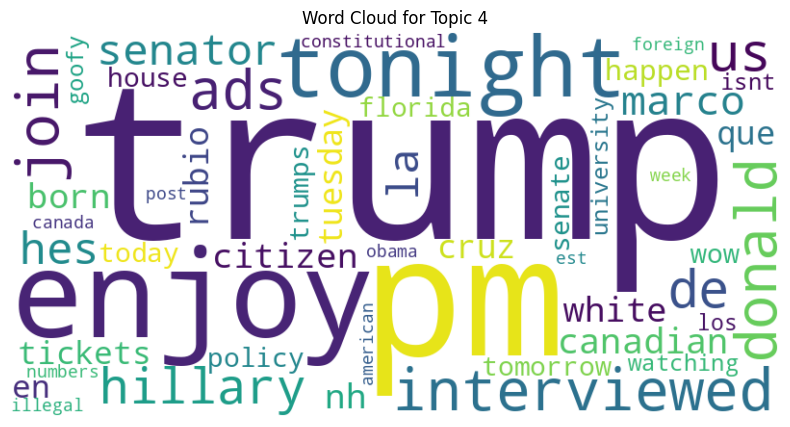

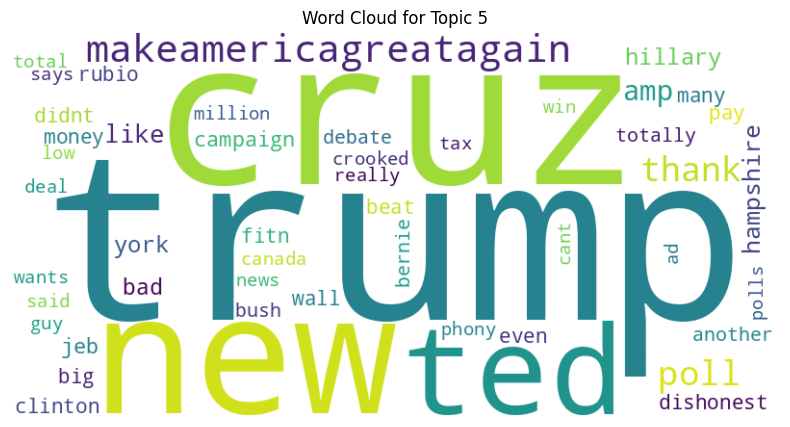

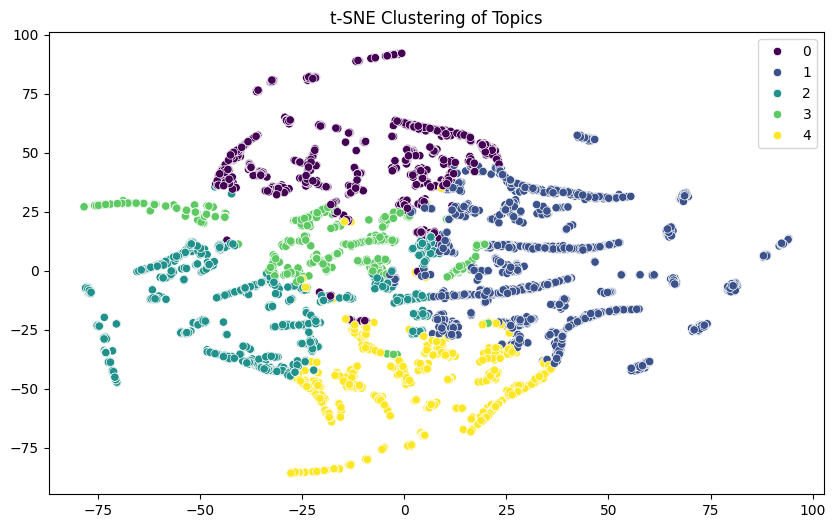

In [ ]:
# Load the cleaned dataset
cleaned_file_path = '/content/drive/MyDrive/cleaned_tweets.csv'  # replace with your actual file path
cleaned_tweets_df = pd.read_csv(cleaned_file_path)

# Display the column names to ensure we are using the correct column
print("Column Names in the Dataset:", cleaned_tweets_df.columns)

# Ensure the correct column name is used
cleaned_text_column = 'Text'

# Convert all entries to strings and handle NaN values
cleaned_tweets_df[cleaned_text_column] = cleaned_tweets_df[cleaned_text_column].astype(str).fillna('')

# Preprocess and tokenize the text for LDA (Gensim)
texts = cleaned_tweets_df[cleaned_text_column].apply(lambda x: x.split())

# Create a dictionary and corpus for LDA (Gensim)
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Apply LDA for topic modeling using Gensim
num_topics = 5
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Function to print the topics
def print_topics(model, num_words=10):
    for idx, topic in model.print_topics(-1, num_words=num_words):
        print(f"Topic {idx + 1}: {topic}")

# Visualize the LDA topics using PyLDAvis
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# Function to plot a word cloud for a topic
def plot_topic_word_cloud(model, topic_index, dictionary, title):
    topic = dict(model.show_topic(topic_index, topn=50))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word clouds for each LDA topic
for i in range(num_topics):
    plot_topic_word_cloud(lda_model, i, dictionary, f"Word Cloud for Topic {i + 1}")

# t-SNE Clustering
lda_corpus = [lda_model[doc] for doc in corpus]
lda_topics = lda_model.get_topics()

# Create an array for the t-SNE input
lda_vectors = gensim.matutils.corpus2dense(lda_corpus, num_terms=lda_model.num_topics).T

# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_lda = tsne_model.fit_transform(lda_vectors)

# Get the dominant topic for each document
dominant_topics = [max(doc, key=lambda item: item[1])[0] if len(doc) > 0 else -1 for doc in lda_corpus]

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_lda[:, 0], y=tsne_lda[:, 1], hue=dominant_topics, palette='viridis')
plt.title('t-SNE Clustering of Topics')
plt.show()

**Comparing with LSA**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Column Names in the Dataset: Index(['Text'], dtype='object')
Top 10 LSA Topics:
Topic 1: trump donald hillary thank great america president make people makeamericagreatagain
Topic 2: hillary clinton crooked president people make amp bernie country bad
Topic 3: great america make thank amp people new vote big makeamericagreatagain
Topic 4: donald america make great president trumps sure says like hes
Topic 5: people amp like cruz ted vote country dont american trumps


Top 10 LDA Topics:
Topic 1: amp trump hillary lets one get votetrump vote thank would
Topic 2: hillary trump donald president people clinton like one us never
Topic 3: great thank america trump iowa make big crowd people tonight
Topic 4: trump pm enjoy tonight interviewed join donald ads us de
Topic 5: trump cruz new ted makeamericagreatagain poll thank amp like hampshire


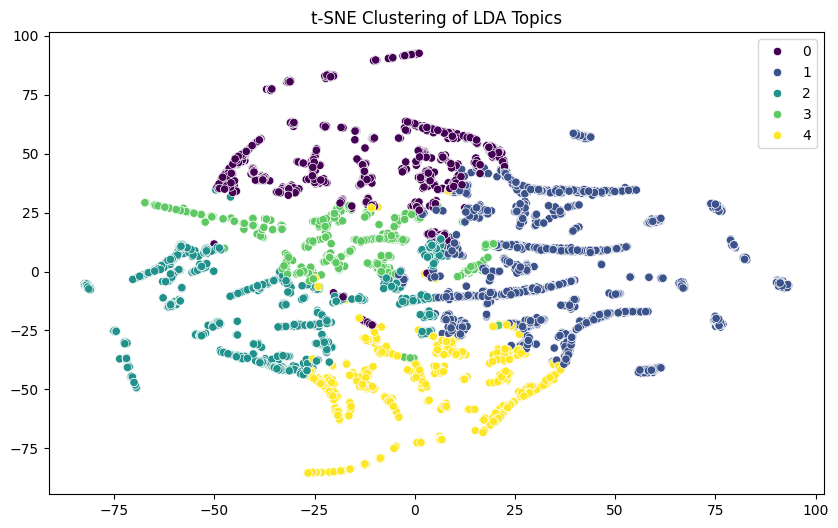

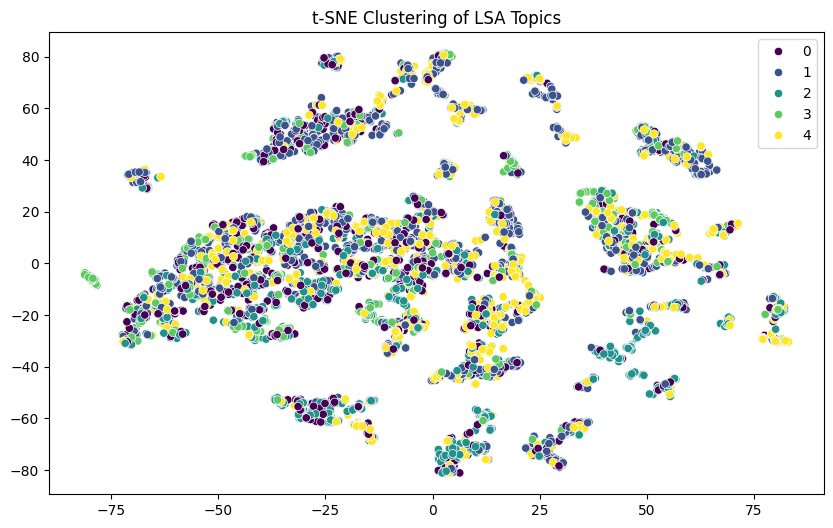

In [ ]:
# Load the cleaned dataset
cleaned_file_path = '/content/drive/MyDrive/cleaned_tweets.csv'  # replace with your actual file path
cleaned_tweets_df = pd.read_csv(cleaned_file_path)

# Load the cleaned dataset
cleaned_tweets_df = pd.read_csv(cleaned_file_path)

# Display the column names to ensure we are using the correct column
print("Column Names in the Dataset:", cleaned_tweets_df.columns)

# Ensure the correct column name is used
cleaned_text_column = 'Text'

# Convert all entries to strings and handle NaN values
cleaned_tweets_df[cleaned_text_column] = cleaned_tweets_df[cleaned_text_column].astype(str).fillna('')

# Tokenize and Vectorize the text data
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(cleaned_tweets_df[cleaned_text_column])

# Apply LDA for topic modeling using Gensim
texts = cleaned_tweets_df[cleaned_text_column].apply(lambda x: x.split())
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

num_topics = 5
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Apply LSA for topic modeling using Scikit-learn
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(dtm)

# Function to print the top words for each topic
def print_top_words(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:"," ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

# Print the top words for each LSA topic
print("Top 10 LSA Topics:")
print_top_words(lsa_model, vectorizer.get_feature_names_out(), num_words=10)

# Print the top words for each LDA topic
def print_lda_top_words(model, num_words=10):
    topics = model.show_topics(formatted=False, num_words=num_words)
    for idx, topic in topics:
        print(f"Topic {idx + 1}:"," ".join([word for word, prob in topic]))

print("\n")
print("Top 10 LDA Topics:")
print_lda_top_words(lda_model, num_words=10)

# t-SNE Clustering
lda_corpus = [lda_model[doc] for doc in corpus]
lda_vectors = gensim.matutils.corpus2dense(lda_corpus, num_terms=lda_model.num_topics).T
tsne_model = TSNE(n_components=2, random_state=42)
tsne_lda = tsne_model.fit_transform(lda_vectors)
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_lsa = tsne_model.fit_transform(lsa_topic_matrix)

# Dominant topics for visualization
dominant_topics = np.argmax(lsa_topic_matrix, axis=1)

# Get the dominant topic for each document
dominant_topics = [max(doc, key=lambda item: item[1])[0] if len(doc) > 0 else -1 for doc in lda_corpus]

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_lda[:, 0], y=tsne_lda[:, 1], hue=dominant_topics, palette='viridis')
plt.title('t-SNE Clustering of LDA Topics')
plt.show()

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_lsa[:, 0], y=tsne_lsa[:, 1], hue=dominant_topics, palette='viridis')
plt.title('t-SNE Clustering of LSA Topics')
plt.show()

# Visualize the LDA topics using PyLDAvis
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

**Prediction and Sentiment Analysis:**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sentiment_label
positive    3700
negative    1842
neutral      902
Name: count, dtype: int64


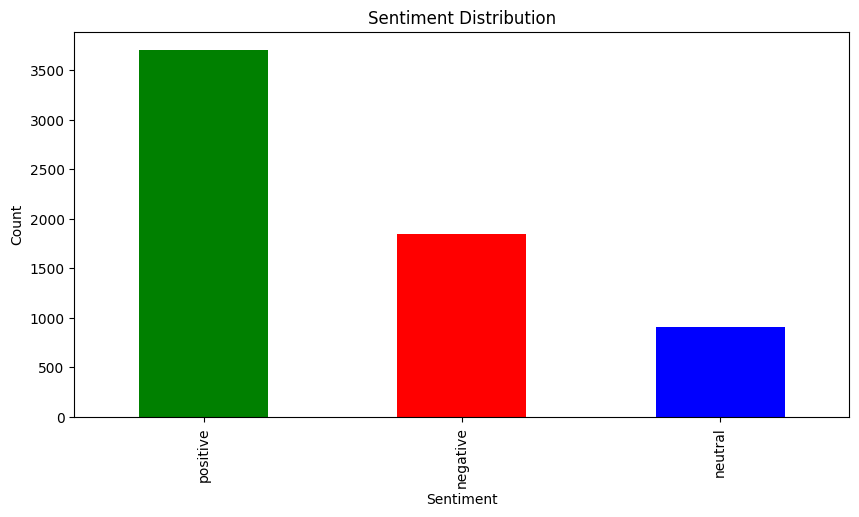

Classification Report:
               precision    recall  f1-score   support

          -1       0.81      0.49      0.61       366
           0       0.90      0.11      0.20       172
           1       0.69      0.96      0.80       751

    accuracy                           0.71      1289
   macro avg       0.80      0.52      0.54      1289
weighted avg       0.75      0.71      0.67      1289

Confusion Matrix:
 [[180   2 184]
 [ 12  19 141]
 [ 31   0 720]]
Accuracy Score: 0.712955779674166


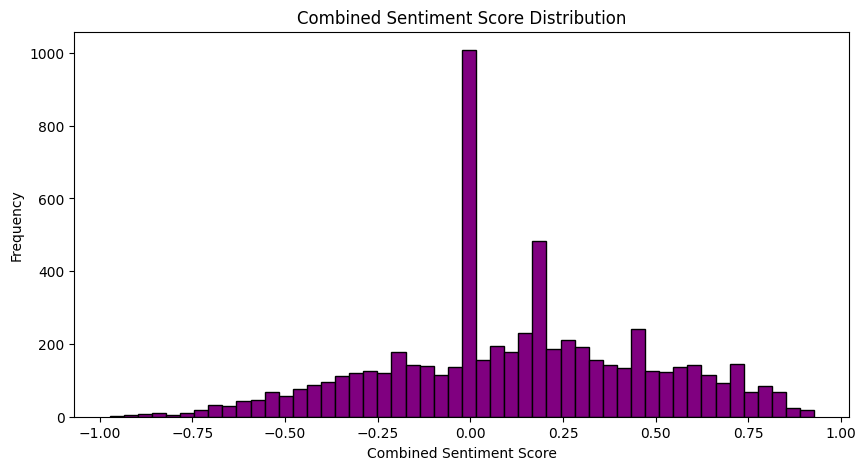

count    6444.000000
mean        0.122274
std         0.353728
min        -0.973000
25%        -0.070625
50%         0.109167
75%         0.371675
max         0.927750
Name: combined_sentiment, dtype: float64


In [ ]:
# Sentiment Analysis using TextBlob
def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_sentiment_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

cleaned_tweets_df['polarity'] = cleaned_tweets_df[cleaned_text_column].apply(get_sentiment_polarity)
cleaned_tweets_df['subjectivity'] = cleaned_tweets_df[cleaned_text_column].apply(get_sentiment_subjectivity)

# Sentiment Analysis using VADER
sid = SentimentIntensityAnalyzer()
cleaned_tweets_df['vader'] = cleaned_tweets_df[cleaned_text_column].apply(lambda x: sid.polarity_scores(x)['compound'])

# Combine both sentiment scores
def combined_sentiment_score(row):
    return (row['polarity'] + row['vader']) / 2

cleaned_tweets_df['combined_sentiment'] = cleaned_tweets_df.apply(combined_sentiment_score, axis=1)

# Label the sentiment as positive, negative, or neutral
def sentiment_label(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

cleaned_tweets_df['sentiment_label'] = cleaned_tweets_df['combined_sentiment'].apply(sentiment_label)

# Print the sentiment distribution
print(cleaned_tweets_df['sentiment_label'].value_counts())

# Visualize the sentiment distribution
plt.figure(figsize=(10, 5))
cleaned_tweets_df['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

# Prediction using Multinomial Naive Bayes
# Encode sentiment labels
cleaned_tweets_df['sentiment_encoded'] = cleaned_tweets_df['sentiment_label'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cleaned_tweets_df[cleaned_text_column], cleaned_tweets_df['sentiment_encoded'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Visualization of Sentiment Analysis
plt.figure(figsize=(10, 5))
plt.hist(cleaned_tweets_df['combined_sentiment'], bins=50, color='purple', edgecolor='black')
plt.xlabel('Combined Sentiment Score')
plt.ylabel('Frequency')
plt.title('Combined Sentiment Score Distribution')
plt.show()

# Display basic statistics for combined sentiment score
print(cleaned_tweets_df['combined_sentiment'].describe())
